In [1]:
import datetime
import pickle
import polars as pl
import ml_utils
import mlflow
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error
import constants
import numpy as np
import optuna
from optuna.integration.mlflow import MLflowCallback

In [2]:
with open("df_all.pkl", "rb") as file:
    df_all = pickle.load(file)

In [3]:
df_all = df_all.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

df_all.head(8)

date,a,b,o,ab,all,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,weekday,month,day_of_year
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,i8,i8,i16
2006-01-01,152,139,194,40,525,0,0,0,0,7,1,1
2006-01-02,53,43,112,19,227,0,0,0,0,1,1,2
2006-01-03,29,21,56,6,112,0,0,0,0,2,1,3
2006-01-04,92,98,165,36,391,0,0,0,0,3,1,4
2006-01-05,149,198,193,42,582,0,0,0,0,4,1,5
2006-01-06,94,77,126,27,324,0,0,0,0,5,1,6
2006-01-07,29,28,48,13,118,0,0,0,0,6,1,7
2006-01-08,218,212,314,51,795,0,0,0,0,7,1,8


In [4]:
for lag in range(1, constants.WINDOW_SIZE+1):
    df_all = df_all.with_columns(
        pl.col("all").shift(lag).alias(f"all_lag_{lag}")
    )

df_all = df_all.drop_nulls()

In [5]:
df_all

date,a,b,o,ab,all,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,weekday,month,day_of_year,all_lag_1,all_lag_2,all_lag_3,all_lag_4,all_lag_5,all_lag_6,all_lag_7
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,i8,i8,i16,i64,i64,i64,i64,i64,i64,i64
2006-01-08,218,212,314,51,795,0,0,0,0,7,1,8,118,324,582,391,112,227,525
2006-01-09,83,95,151,17,346,0,0,0,0,1,1,9,795,118,324,582,391,112,227
2006-01-10,1,0,1,0,2,1,0,1,0,2,1,10,346,795,118,324,582,391,112
2006-01-11,128,111,179,30,448,0,0,0,0,3,1,11,2,346,795,118,324,582,391
2006-01-12,211,236,316,42,805,0,0,0,0,4,1,12,448,2,346,795,118,324,582
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-06-01,556,589,1056,65,2266,0,0,0,0,7,6,152,1600,946,1379,1439,1181,1024,3215
2025-06-02,442,509,781,60,1792,0,1,0,0,1,6,153,2266,1600,946,1379,1439,1181,1024
2025-06-03,282,293,460,49,1084,0,0,0,0,2,6,154,1792,2266,1600,946,1379,1439,1181


In [6]:
X_seq = df_all.select([f"all_lag_{lag}" for lag in range(1, constants.WINDOW_SIZE+1)]).to_numpy().reshape(-1, constants.WINDOW_SIZE, 1)
X_features = df_all.select(["weekday", "month", "day_of_year", "is_religion_or_culture_holiday", "is_other_holiday", "is_low_donation_holiday", "is_high_donation_holiday"]).to_numpy()
y = df_all['all'].to_numpy()

In [7]:
# Set up scalers 
from sklearn.preprocessing import RobustScaler

y_scaler = RobustScaler()
X_scaler = RobustScaler()

In [8]:
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
X_features_scaled = X_scaler.fit_transform(X_features)
X_seq_scaled = y_scaler.transform(X_seq.reshape(-1, 1)).reshape(-1, constants.WINDOW_SIZE, 1)

In [9]:
with open('shared/x_scaler.pkl', 'wb') as file:
    pickle.dump(X_scaler, file)
    
with open('shared/y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)

In [ ]:
X_seq_train, X_seq_val, X_seq_test, X_features_train, X_features_val, X_features_test, y_train, y_val, y_test = ml_utils.train_val_test_split_feature_data(
    X_seq_scaled,
    X_features_scaled,
    y_scaled,
    constants.TRAIN_FRAC,
    constants.VAL_FRAC
)

In [11]:
experiment_name = f"{constants.EXPERIMENT_NAME}_{datetime.datetime.now().strftime('%Y%m%d')}"
experiment_id = ml_utils.get_or_create_mlflow_experiment(experiment_name)
mlflow.set_experiment(experiment_name)
mlflow_callback = MLflowCallback(
    tracking_uri = mlflow.get_tracking_uri(),
    metric_name = "val_loss"
)

In [12]:
def objective(trial):
    seq_type = trial.suggest_categorical("seq_type", ["LSTM", "SimpleRNN", "GRU"])
    seq_units = trial.suggest_int("seq_units", 12, 48)
    dense_units = trial.suggest_int("dense_units", 4, 12)
    activation = trial.suggest_categorical("activation", ["tanh", "relu", "mish"])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    dropout = trial.suggest_float("dropout", 0.01, 0.1)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)  # log scale for LR
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    ml_utils.run_experiment(
        X_seq_train, X_features_train, y_train,
        X_seq_val, X_features_val, y_val,
        seq_type=seq_type,
        seq_units=seq_units,
        dense_units=dense_units,
        activation=activation,
        optimizer=optimizer,
        dropout=dropout,
        learning_rate=learning_rate,
        batch_size=batch_size,
        experiment_id=experiment_id
    )
    
    runs = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["start_time DESC"])
    val_loss = runs.iloc[0]["metrics.val_loss"]
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=constants.N_TRIALS, callbacks=[mlflow_callback])

[I 2025-06-14 16:15:41,865] A new study created in memory with name: no-name-89ed5c5d-5384-49a2-b783-1d854b3fb61c


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1687 - mae: 0.2955
Validation Loss: 0.18318654596805573, Validation MAE: 0.3116467297077179


[I 2025-06-14 16:16:23,306] Trial 0 finished with value: 0.18318654596805573 and parameters: {'seq_type': 'LSTM', 'seq_units': 28, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.06569900328843033, 'learning_rate': 0.054781280553340105, 'batch_size': 128}. Best is trial 0 with value: 0.18318654596805573.
2025/06/14 16:16:23 INFO mlflow.tracking.fluent: Experiment with name 'no-name-89ed5c5d-5384-49a2-b783-1d854b3fb61c' does not exist. Creating a new experiment.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1750 - mae: 0.2922
Validation Loss: 0.18950912356376648, Validation MAE: 0.3105885684490204


[I 2025-06-14 16:17:15,475] Trial 1 finished with value: 0.18950912356376648 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 21, 'dense_units': 9, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.04978042276404585, 'learning_rate': 0.026123215637597383, 'batch_size': 32}. Best is trial 0 with value: 0.18318654596805573.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2509 - mae: 0.3522
Validation Loss: 0.25714433193206787, Validation MAE: 0.3678458631038666


[I 2025-06-14 16:17:37,147] Trial 2 finished with value: 0.2571443021297455 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 18, 'dense_units': 6, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.08427910355716237, 'learning_rate': 0.0738521295262768, 'batch_size': 128}. Best is trial 0 with value: 0.18318654596805573.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2188 - mae: 0.3175
Validation Loss: 0.22772960364818573, Validation MAE: 0.3300457298755646


[I 2025-06-14 16:21:10,607] Trial 3 finished with value: 0.22772958874702454 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 46, 'dense_units': 6, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.08958269836367078, 'learning_rate': 0.00010170565985469461, 'batch_size': 128}. Best is trial 0 with value: 0.18318654596805573.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1969 - mae: 0.3153 
Validation Loss: 0.19306360185146332, Validation MAE: 0.3180753290653229


[I 2025-06-14 16:21:42,156] Trial 4 finished with value: 0.19306360185146332 and parameters: {'seq_type': 'LSTM', 'seq_units': 20, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.01677820110015494, 'learning_rate': 0.007446514512494084, 'batch_size': 128}. Best is trial 0 with value: 0.18318654596805573.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1964 - mae: 0.3007
Validation Loss: 0.20091691613197327, Validation MAE: 0.31353387236595154


[I 2025-06-14 16:22:08,907] Trial 5 finished with value: 0.20091691613197327 and parameters: {'seq_type': 'GRU', 'seq_units': 14, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.021269458378274483, 'learning_rate': 0.005752123746444418, 'batch_size': 128}. Best is trial 0 with value: 0.18318654596805573.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2333 - mae: 0.3480 
Validation Loss: 0.24862989783287048, Validation MAE: 0.36466696858406067


[I 2025-06-14 16:22:30,592] Trial 6 finished with value: 0.24862989783287048 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 28, 'dense_units': 12, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.034473050304762845, 'learning_rate': 0.06440411156069664, 'batch_size': 128}. Best is trial 0 with value: 0.18318654596805573.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1950 - mae: 0.3095 
Validation Loss: 0.2110302597284317, Validation MAE: 0.3207029700279236


[I 2025-06-14 16:22:59,742] Trial 7 finished with value: 0.2110302597284317 and parameters: {'seq_type': 'LSTM', 'seq_units': 15, 'dense_units': 5, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.0661451996724482, 'learning_rate': 0.01501069304654427, 'batch_size': 128}. Best is trial 0 with value: 0.18318654596805573.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1775 - mae: 0.2927 
Validation Loss: 0.1884939968585968, Validation MAE: 0.3058006167411804


[I 2025-06-14 16:23:41,127] Trial 8 finished with value: 0.1884939968585968 and parameters: {'seq_type': 'GRU', 'seq_units': 16, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.012899882719883637, 'learning_rate': 0.005451480691824128, 'batch_size': 64}. Best is trial 0 with value: 0.18318654596805573.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1561 - mae: 0.2850
Validation Loss: 0.16899187862873077, Validation MAE: 0.2930673658847809


[I 2025-06-14 16:24:39,683] Trial 9 finished with value: 0.16899186372756958 and parameters: {'seq_type': 'GRU', 'seq_units': 23, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06805335016147561, 'learning_rate': 0.0025143155742815364, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1993 - mae: 0.3009
Validation Loss: 0.21739798784255981, Validation MAE: 0.31953996419906616


[I 2025-06-14 16:25:20,387] Trial 10 finished with value: 0.217398002743721 and parameters: {'seq_type': 'GRU', 'seq_units': 39, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09994404466081758, 'learning_rate': 0.0007588203181898926, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1792 - mae: 0.2935
Validation Loss: 0.19547045230865479, Validation MAE: 0.30747127532958984


[I 2025-06-14 16:26:31,799] Trial 11 finished with value: 0.19547045230865479 and parameters: {'seq_type': 'LSTM', 'seq_units': 30, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06532155418555664, 'learning_rate': 0.0010668125153444723, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1820 - mae: 0.2951
Validation Loss: 0.20185282826423645, Validation MAE: 0.3121427893638611


[I 2025-06-14 16:28:46,297] Trial 12 finished with value: 0.20185282826423645 and parameters: {'seq_type': 'GRU', 'seq_units': 26, 'dense_units': 10, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.054676755213512444, 'learning_rate': 0.0009690996740729879, 'batch_size': 32}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1721 - mae: 0.2912
Validation Loss: 0.18257632851600647, Validation MAE: 0.3042457401752472


[I 2025-06-14 16:29:47,392] Trial 13 finished with value: 0.18257629871368408 and parameters: {'seq_type': 'LSTM', 'seq_units': 34, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07258485063720375, 'learning_rate': 0.00226152437135715, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1760 - mae: 0.2909 
Validation Loss: 0.19231492280960083, Validation MAE: 0.3041819930076599


[I 2025-06-14 16:30:40,127] Trial 14 finished with value: 0.19231492280960083 and parameters: {'seq_type': 'GRU', 'seq_units': 36, 'dense_units': 7, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07894260375635234, 'learning_rate': 0.0019601681872358115, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1992 - mae: 0.3015 
Validation Loss: 0.21148905158042908, Validation MAE: 0.31698012351989746


[I 2025-06-14 16:31:56,971] Trial 15 finished with value: 0.21148903667926788 and parameters: {'seq_type': 'LSTM', 'seq_units': 37, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.042164484913759744, 'learning_rate': 0.00027325893344105684, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1763 - mae: 0.2913
Validation Loss: 0.18665044009685516, Validation MAE: 0.3009365200996399


[I 2025-06-14 16:32:37,867] Trial 16 finished with value: 0.18665044009685516 and parameters: {'seq_type': 'LSTM', 'seq_units': 24, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0752136849368349, 'learning_rate': 0.002112870938904647, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2021 - mae: 0.3036
Validation Loss: 0.2210327684879303, Validation MAE: 0.3232448101043701


[I 2025-06-14 16:33:41,151] Trial 17 finished with value: 0.2210327386856079 and parameters: {'seq_type': 'GRU', 'seq_units': 33, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07007228753525763, 'learning_rate': 0.00037695923990579007, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1975 - mae: 0.2980
Validation Loss: 0.20706447958946228, Validation MAE: 0.3115251958370209


[I 2025-06-14 16:34:24,270] Trial 18 finished with value: 0.2070644646883011 and parameters: {'seq_type': 'LSTM', 'seq_units': 44, 'dense_units': 7, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.09518415189802497, 'learning_rate': 0.0035500444094982635, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1781 - mae: 0.2994 
Validation Loss: 0.18610426783561707, Validation MAE: 0.3104802668094635


[I 2025-06-14 16:35:26,209] Trial 19 finished with value: 0.18610426783561707 and parameters: {'seq_type': 'GRU', 'seq_units': 41, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.05893554912764613, 'learning_rate': 0.011625064071716821, 'batch_size': 32}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1920 - mae: 0.2981
Validation Loss: 0.20760466158390045, Validation MAE: 0.31396105885505676


[I 2025-06-14 16:36:08,102] Trial 20 finished with value: 0.20760466158390045 and parameters: {'seq_type': 'GRU', 'seq_units': 33, 'dense_units': 9, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.033208114856645175, 'learning_rate': 0.0022100028322367144, 'batch_size': 64}. Best is trial 9 with value: 0.16899186372756958.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1574 - mae: 0.2821
Validation Loss: 0.16851575672626495, Validation MAE: 0.29763898253440857


[I 2025-06-14 16:36:51,223] Trial 21 finished with value: 0.16851574182510376 and parameters: {'seq_type': 'LSTM', 'seq_units': 24, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.07655397125341182, 'learning_rate': 0.03209189860421645, 'batch_size': 64}. Best is trial 21 with value: 0.16851574182510376.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1895 - mae: 0.3046
Validation Loss: 0.1959128975868225, Validation MAE: 0.31491556763648987


[I 2025-06-14 16:37:22,188] Trial 22 finished with value: 0.1959128975868225 and parameters: {'seq_type': 'LSTM', 'seq_units': 23, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.07869479875932991, 'learning_rate': 0.02925229769530914, 'batch_size': 64}. Best is trial 21 with value: 0.16851574182510376.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1643 - mae: 0.2844
Validation Loss: 0.17629505693912506, Validation MAE: 0.296962708234787


[I 2025-06-14 16:38:16,600] Trial 23 finished with value: 0.17629507184028625 and parameters: {'seq_type': 'LSTM', 'seq_units': 33, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.08554293308139191, 'learning_rate': 0.0038825688807307196, 'batch_size': 64}. Best is trial 21 with value: 0.16851574182510376.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1717 - mae: 0.2987
Validation Loss: 0.18002396821975708, Validation MAE: 0.3096548020839691


[I 2025-06-14 16:38:58,099] Trial 24 finished with value: 0.18002396821975708 and parameters: {'seq_type': 'LSTM', 'seq_units': 25, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.0856668349787901, 'learning_rate': 0.026187244310034004, 'batch_size': 64}. Best is trial 21 with value: 0.16851574182510376.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1771 - mae: 0.2889
Validation Loss: 0.1876809448003769, Validation MAE: 0.3044583797454834


[I 2025-06-14 16:39:34,038] Trial 25 finished with value: 0.1876809448003769 and parameters: {'seq_type': 'LSTM', 'seq_units': 31, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.08941898774856916, 'learning_rate': 0.01320539483856438, 'batch_size': 64}. Best is trial 21 with value: 0.16851574182510376.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1813 - mae: 0.2974
Validation Loss: 0.18784202635288239, Validation MAE: 0.30626675486564636


[I 2025-06-14 16:41:31,739] Trial 26 finished with value: 0.18784202635288239 and parameters: {'seq_type': 'LSTM', 'seq_units': 21, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.05909757959376443, 'learning_rate': 0.0046663219477195254, 'batch_size': 32}. Best is trial 21 with value: 0.16851574182510376.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1835 - mae: 0.2918
Validation Loss: 0.2038196623325348, Validation MAE: 0.3122795522212982


[I 2025-06-14 16:43:16,476] Trial 27 finished with value: 0.2038196623325348 and parameters: {'seq_type': 'LSTM', 'seq_units': 12, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.08228102858952806, 'learning_rate': 0.0005633189802857453, 'batch_size': 64}. Best is trial 21 with value: 0.16851574182510376.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1806 - mae: 0.2930
Validation Loss: 0.19519607722759247, Validation MAE: 0.3075331151485443


[I 2025-06-14 16:43:46,997] Trial 28 finished with value: 0.19519604742527008 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 28, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.09582014180143042, 'learning_rate': 0.009371411864377243, 'batch_size': 64}. Best is trial 21 with value: 0.16851574182510376.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1513 - mae: 0.2783
Validation Loss: 0.1659950464963913, Validation MAE: 0.2923315465450287


[I 2025-06-14 16:44:29,811] Trial 29 finished with value: 0.1659950464963913 and parameters: {'seq_type': 'GRU', 'seq_units': 30, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.06969370235803933, 'learning_rate': 0.03251616100359014, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1856 - mae: 0.3133
Validation Loss: 0.20441006124019623, Validation MAE: 0.32890695333480835


[I 2025-06-14 16:45:10,536] Trial 30 finished with value: 0.20441006124019623 and parameters: {'seq_type': 'GRU', 'seq_units': 27, 'dense_units': 10, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.06537986513199881, 'learning_rate': 0.04125167596935586, 'batch_size': 32}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1714 - mae: 0.2906
Validation Loss: 0.18065693974494934, Validation MAE: 0.2997501790523529


[I 2025-06-14 16:45:41,486] Trial 31 finished with value: 0.18065693974494934 and parameters: {'seq_type': 'GRU', 'seq_units': 31, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.0722396605884181, 'learning_rate': 0.01868935932192986, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1672 - mae: 0.3003
Validation Loss: 0.1760890632867813, Validation MAE: 0.310223251581192


[I 2025-06-14 16:46:16,626] Trial 32 finished with value: 0.1760890632867813 and parameters: {'seq_type': 'GRU', 'seq_units': 19, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.04905807418247364, 'learning_rate': 0.038518542836139584, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1831 - mae: 0.3019
Validation Loss: 0.20333176851272583, Validation MAE: 0.32137274742126465


[I 2025-06-14 16:46:48,637] Trial 33 finished with value: 0.20333179831504822 and parameters: {'seq_type': 'GRU', 'seq_units': 18, 'dense_units': 10, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.053172055523162794, 'learning_rate': 0.09665869223082095, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1792 - mae: 0.3017
Validation Loss: 0.1946188509464264, Validation MAE: 0.3188110888004303


[I 2025-06-14 16:47:26,963] Trial 34 finished with value: 0.19461886584758759 and parameters: {'seq_type': 'GRU', 'seq_units': 22, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.06031826400766081, 'learning_rate': 0.04701764454213361, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1604 - mae: 0.2890
Validation Loss: 0.1761299967765808, Validation MAE: 0.29998502135276794


[I 2025-06-14 16:48:19,751] Trial 35 finished with value: 0.1761299967765808 and parameters: {'seq_type': 'GRU', 'seq_units': 19, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.04352127446435008, 'learning_rate': 0.03512057381246886, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1728 - mae: 0.2869 
Validation Loss: 0.1857970654964447, Validation MAE: 0.29922834038734436


[I 2025-06-14 16:48:57,760] Trial 36 finished with value: 0.1857970952987671 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 17, 'dense_units': 12, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.047684770142656124, 'learning_rate': 0.022372889693068086, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1679 - mae: 0.2941
Validation Loss: 0.18922390043735504, Validation MAE: 0.3179151117801666


[I 2025-06-14 16:49:29,636] Trial 37 finished with value: 0.18922387063503265 and parameters: {'seq_type': 'GRU', 'seq_units': 20, 'dense_units': 9, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.03403804720776911, 'learning_rate': 0.06033326479764426, 'batch_size': 128}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1787 - mae: 0.2975
Validation Loss: 0.20173035562038422, Validation MAE: 0.31614306569099426


[I 2025-06-14 16:50:20,727] Trial 38 finished with value: 0.20173035562038422 and parameters: {'seq_type': 'GRU', 'seq_units': 23, 'dense_units': 10, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.04928060277642067, 'learning_rate': 0.006765137181563617, 'batch_size': 32}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1811 - mae: 0.3061 
Validation Loss: 0.18801841139793396, Validation MAE: 0.3144286572933197


[I 2025-06-14 16:50:48,396] Trial 39 finished with value: 0.18801841139793396 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 25, 'dense_units': 12, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.06225636051071511, 'learning_rate': 0.017401043393123247, 'batch_size': 128}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2046 - mae: 0.2985
Validation Loss: 0.2267267405986786, Validation MAE: 0.3244470953941345


[I 2025-06-14 16:51:25,264] Trial 40 finished with value: 0.2267267256975174 and parameters: {'seq_type': 'GRU', 'seq_units': 29, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.02811391946986425, 'learning_rate': 0.09122316318235194, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1797 - mae: 0.3035
Validation Loss: 0.19418364763259888, Validation MAE: 0.31634461879730225


[I 2025-06-14 16:52:01,273] Trial 41 finished with value: 0.19418364763259888 and parameters: {'seq_type': 'GRU', 'seq_units': 19, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.04337294709800454, 'learning_rate': 0.03960848567101359, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1760 - mae: 0.2951
Validation Loss: 0.19480189681053162, Validation MAE: 0.31027349829673767


[I 2025-06-14 16:52:39,384] Trial 42 finished with value: 0.19480189681053162 and parameters: {'seq_type': 'GRU', 'seq_units': 15, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.041628558966324024, 'learning_rate': 0.033234047098546125, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1919 - mae: 0.3059
Validation Loss: 0.20540961623191833, Validation MAE: 0.32630306482315063


[I 2025-06-14 16:53:09,474] Trial 43 finished with value: 0.20540963113307953 and parameters: {'seq_type': 'GRU', 'seq_units': 21, 'dense_units': 11, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.06795938786216818, 'learning_rate': 0.05692195190391736, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1817 - mae: 0.3045
Validation Loss: 0.20731253921985626, Validation MAE: 0.32870322465896606


[I 2025-06-14 16:53:41,687] Trial 44 finished with value: 0.20731256902217865 and parameters: {'seq_type': 'GRU', 'seq_units': 18, 'dense_units': 10, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.04576457383092379, 'learning_rate': 0.06860892336621432, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2028 - mae: 0.3169
Validation Loss: 0.2064828872680664, Validation MAE: 0.32198113203048706


[I 2025-06-14 16:54:25,909] Trial 45 finished with value: 0.2064828872680664 and parameters: {'seq_type': 'GRU', 'seq_units': 12, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.052602016968153115, 'learning_rate': 0.0088180330361927, 'batch_size': 128}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1964 - mae: 0.3061
Validation Loss: 0.2109363079071045, Validation MAE: 0.31480637192726135


[I 2025-06-14 16:55:39,338] Trial 46 finished with value: 0.21093633770942688 and parameters: {'seq_type': 'GRU', 'seq_units': 26, 'dense_units': 5, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.07558731603774732, 'learning_rate': 0.001406710731672098, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1812 - mae: 0.3045
Validation Loss: 0.1898728758096695, Validation MAE: 0.31479427218437195


[I 2025-06-14 16:56:15,319] Trial 47 finished with value: 0.1898728758096695 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 16, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.03669595161617128, 'learning_rate': 0.02379550336318027, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2020 - mae: 0.3278 
Validation Loss: 0.22996844351291656, Validation MAE: 0.34937822818756104


[I 2025-06-14 16:56:44,519] Trial 48 finished with value: 0.22996845841407776 and parameters: {'seq_type': 'GRU', 'seq_units': 20, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.05622324646401863, 'learning_rate': 0.03548061961725214, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1590 - mae: 0.2808 
Validation Loss: 0.16963247954845428, Validation MAE: 0.29486826062202454


[I 2025-06-14 16:57:27,342] Trial 49 finished with value: 0.16963247954845428 and parameters: {'seq_type': 'GRU', 'seq_units': 14, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06396153720250355, 'learning_rate': 0.0113455831445432, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2364 - mae: 0.3389 
Validation Loss: 0.25179243087768555, Validation MAE: 0.35812363028526306


[I 2025-06-14 16:59:37,085] Trial 50 finished with value: 0.25179243087768555 and parameters: {'seq_type': 'GRU', 'seq_units': 14, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06330259192666927, 'learning_rate': 0.00013975790485480942, 'batch_size': 128}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1676 - mae: 0.2846 
Validation Loss: 0.18357959389686584, Validation MAE: 0.3005218207836151


[I 2025-06-14 17:00:21,099] Trial 51 finished with value: 0.18357959389686584 and parameters: {'seq_type': 'GRU', 'seq_units': 13, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06839826229665791, 'learning_rate': 0.016320568301900436, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1570 - mae: 0.2787 
Validation Loss: 0.1768258810043335, Validation MAE: 0.3000565767288208


[I 2025-06-14 17:00:51,037] Trial 52 finished with value: 0.1768258810043335 and parameters: {'seq_type': 'GRU', 'seq_units': 17, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07515646659688723, 'learning_rate': 0.02133975526869303, 'batch_size': 64}. Best is trial 29 with value: 0.1659950464963913.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1504 - mae: 0.2784 
Validation Loss: 0.16381405293941498, Validation MAE: 0.29151856899261475


[I 2025-06-14 17:01:31,694] Trial 53 finished with value: 0.16381403803825378 and parameters: {'seq_type': 'GRU', 'seq_units': 23, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.05610957418215056, 'learning_rate': 0.011845855957136865, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1625 - mae: 0.2806 
Validation Loss: 0.17638850212097168, Validation MAE: 0.301615834236145


[I 2025-06-14 17:02:16,574] Trial 54 finished with value: 0.17638851702213287 and parameters: {'seq_type': 'GRU', 'seq_units': 23, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.056768721542797405, 'learning_rate': 0.01071548193406956, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1653 - mae: 0.2845 
Validation Loss: 0.1850052773952484, Validation MAE: 0.30080822110176086


[I 2025-06-14 17:02:55,924] Trial 55 finished with value: 0.1850052773952484 and parameters: {'seq_type': 'GRU', 'seq_units': 24, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07047067220858165, 'learning_rate': 0.006784150686103181, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1577 - mae: 0.2753
Validation Loss: 0.17042294144630432, Validation MAE: 0.29499199986457825


[I 2025-06-14 17:03:45,444] Trial 56 finished with value: 0.1704229712486267 and parameters: {'seq_type': 'GRU', 'seq_units': 48, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07946035631194817, 'learning_rate': 0.013386711529124387, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1681 - mae: 0.2886
Validation Loss: 0.1841481477022171, Validation MAE: 0.30727270245552063


[I 2025-06-14 17:04:44,847] Trial 57 finished with value: 0.1841481477022171 and parameters: {'seq_type': 'GRU', 'seq_units': 48, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08047730497151273, 'learning_rate': 0.015414658992140725, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2752 - mae: 0.3613
Validation Loss: 0.29982590675354004, Validation MAE: 0.38146913051605225


[I 2025-06-14 17:05:44,844] Trial 58 finished with value: 0.29982590675354004 and parameters: {'seq_type': 'LSTM', 'seq_units': 40, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07636550718277106, 'learning_rate': 0.0028919206577147326, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1858 - mae: 0.2969 
Validation Loss: 0.19509290158748627, Validation MAE: 0.308286190032959


[I 2025-06-14 17:06:12,582] Trial 59 finished with value: 0.19509290158748627 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 43, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08765082479545379, 'learning_rate': 0.0042958803675352455, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1745 - mae: 0.2946
Validation Loss: 0.1861560046672821, Validation MAE: 0.3066786825656891


[I 2025-06-14 17:07:39,574] Trial 60 finished with value: 0.18615597486495972 and parameters: {'seq_type': 'GRU', 'seq_units': 38, 'dense_units': 7, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07233745535459032, 'learning_rate': 0.0054144003632617685, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1563 - mae: 0.2821
Validation Loss: 0.17608605325222015, Validation MAE: 0.29954513907432556


[I 2025-06-14 17:09:04,130] Trial 61 finished with value: 0.17608605325222015 and parameters: {'seq_type': 'GRU', 'seq_units': 27, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06638736502511776, 'learning_rate': 0.012205628900496228, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1631 - mae: 0.2781
Validation Loss: 0.17468543350696564, Validation MAE: 0.29122668504714966


[I 2025-06-14 17:10:49,777] Trial 62 finished with value: 0.17468543350696564 and parameters: {'seq_type': 'GRU', 'seq_units': 35, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06384491988656774, 'learning_rate': 0.012986097289558884, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1724 - mae: 0.2884
Validation Loss: 0.18266718089580536, Validation MAE: 0.3008273243904114


[I 2025-06-14 17:12:29,030] Trial 63 finished with value: 0.18266718089580536 and parameters: {'seq_type': 'GRU', 'seq_units': 34, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08163188736907555, 'learning_rate': 0.0028843888523493143, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1688 - mae: 0.2876
Validation Loss: 0.17739824950695038, Validation MAE: 0.3005731999874115


[I 2025-06-14 17:13:44,137] Trial 64 finished with value: 0.17739823460578918 and parameters: {'seq_type': 'LSTM', 'seq_units': 36, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06263825175895446, 'learning_rate': 0.008686356999284042, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1691 - mae: 0.2890
Validation Loss: 0.17706571519374847, Validation MAE: 0.2972487807273865


[I 2025-06-14 17:16:25,621] Trial 65 finished with value: 0.17706573009490967 and parameters: {'seq_type': 'GRU', 'seq_units': 46, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07851381182635207, 'learning_rate': 0.0015023415895542777, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1542 - mae: 0.2786
Validation Loss: 0.16607548296451569, Validation MAE: 0.2910214066505432


[I 2025-06-14 17:17:45,837] Trial 66 finished with value: 0.16607548296451569 and parameters: {'seq_type': 'GRU', 'seq_units': 31, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.05983137323035588, 'learning_rate': 0.012138964902808221, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1469 - mae: 0.2632
Validation Loss: 0.16830214858055115, Validation MAE: 0.28750166296958923


[I 2025-06-14 17:19:14,167] Trial 67 finished with value: 0.16830214858055115 and parameters: {'seq_type': 'LSTM', 'seq_units': 31, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06982624182424443, 'learning_rate': 0.02651082367965843, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1898 - mae: 0.2904
Validation Loss: 0.20679624378681183, Validation MAE: 0.3083088994026184


[I 2025-06-14 17:21:04,949] Trial 68 finished with value: 0.20679624378681183 and parameters: {'seq_type': 'LSTM', 'seq_units': 31, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0592020772191805, 'learning_rate': 0.020790717089794283, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1979 - mae: 0.3040
Validation Loss: 0.2189452201128006, Validation MAE: 0.3248995840549469


[I 2025-06-14 17:22:26,382] Trial 69 finished with value: 0.2189452201128006 and parameters: {'seq_type': 'LSTM', 'seq_units': 30, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06924668245583021, 'learning_rate': 0.028480298404759154, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1628 - mae: 0.2825
Validation Loss: 0.18341504037380219, Validation MAE: 0.30544114112854004


[I 2025-06-14 17:25:14,809] Trial 70 finished with value: 0.18341504037380219 and parameters: {'seq_type': 'LSTM', 'seq_units': 29, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.053736396062715464, 'learning_rate': 0.028292421479765684, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1718 - mae: 0.2962
Validation Loss: 0.19155386090278625, Validation MAE: 0.31973716616630554


[I 2025-06-14 17:26:54,898] Trial 71 finished with value: 0.19155386090278625 and parameters: {'seq_type': 'LSTM', 'seq_units': 27, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07231948255294497, 'learning_rate': 0.04697076258845566, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1570 - mae: 0.2838 
Validation Loss: 0.17391254007816315, Validation MAE: 0.3028145432472229


[I 2025-06-14 17:28:08,139] Trial 72 finished with value: 0.17391254007816315 and parameters: {'seq_type': 'LSTM', 'seq_units': 32, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06080311500158453, 'learning_rate': 0.01404416661433841, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1686 - mae: 0.2921 
Validation Loss: 0.1798221617937088, Validation MAE: 0.3038703501224518


[I 2025-06-14 17:28:32,201] Trial 73 finished with value: 0.1798221617937088 and parameters: {'seq_type': 'GRU', 'seq_units': 25, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06595482914733113, 'learning_rate': 0.007906802223346046, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1585 - mae: 0.2827 
Validation Loss: 0.1774507611989975, Validation MAE: 0.2961357831954956


[I 2025-06-14 17:29:01,311] Trial 74 finished with value: 0.1774507462978363 and parameters: {'seq_type': 'GRU', 'seq_units': 22, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0736639476407725, 'learning_rate': 0.005781277122814642, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1605 - mae: 0.2923 
Validation Loss: 0.17147143185138702, Validation MAE: 0.3022971451282501


[I 2025-06-14 17:29:25,576] Trial 75 finished with value: 0.17147140204906464 and parameters: {'seq_type': 'LSTM', 'seq_units': 28, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.08398581909729565, 'learning_rate': 0.019491274894714333, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1739 - mae: 0.2970 
Validation Loss: 0.1868337243795395, Validation MAE: 0.3055460453033447


[I 2025-06-14 17:30:02,594] Trial 76 finished with value: 0.1868337243795395 and parameters: {'seq_type': 'GRU', 'seq_units': 42, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07778252931943673, 'learning_rate': 0.009469562308009891, 'batch_size': 128}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1953 - mae: 0.3060 
Validation Loss: 0.22713233530521393, Validation MAE: 0.33142367005348206


[I 2025-06-14 17:30:22,102] Trial 77 finished with value: 0.22713230550289154 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 32, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.05735473314321361, 'learning_rate': 0.04829710182257171, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1695 - mae: 0.2843 
Validation Loss: 0.18030165135860443, Validation MAE: 0.29997000098228455


[I 2025-06-14 17:31:00,816] Trial 78 finished with value: 0.18030165135860443 and parameters: {'seq_type': 'GRU', 'seq_units': 29, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09184107037126177, 'learning_rate': 0.011007267169481024, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1710 - mae: 0.3002 
Validation Loss: 0.18084684014320374, Validation MAE: 0.31187698245048523


[I 2025-06-14 17:31:39,880] Trial 79 finished with value: 0.18084684014320374 and parameters: {'seq_type': 'LSTM', 'seq_units': 38, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06916608090193169, 'learning_rate': 0.025394154350704606, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1827 - mae: 0.3019 
Validation Loss: 0.18726846575737, Validation MAE: 0.31306934356689453


[I 2025-06-14 17:32:18,458] Trial 80 finished with value: 0.1872684508562088 and parameters: {'seq_type': 'GRU', 'seq_units': 24, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.05200742500317254, 'learning_rate': 0.017493310661995942, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1628 - mae: 0.2934 
Validation Loss: 0.17017725110054016, Validation MAE: 0.30159249901771545


[I 2025-06-14 17:32:44,779] Trial 81 finished with value: 0.17017725110054016 and parameters: {'seq_type': 'LSTM', 'seq_units': 28, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.08462993005160051, 'learning_rate': 0.020530670173562204, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1810 - mae: 0.3057 
Validation Loss: 0.19268620014190674, Validation MAE: 0.31941133737564087


[I 2025-06-14 17:33:14,397] Trial 82 finished with value: 0.19268620014190674 and parameters: {'seq_type': 'LSTM', 'seq_units': 26, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.08365045245860118, 'learning_rate': 0.015204546564088647, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1800 - mae: 0.3036 
Validation Loss: 0.18935510516166687, Validation MAE: 0.31110432744026184


[I 2025-06-14 17:33:40,116] Trial 83 finished with value: 0.18935509026050568 and parameters: {'seq_type': 'LSTM', 'seq_units': 32, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.07091675325821473, 'learning_rate': 0.029368358767120795, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1803 - mae: 0.2920 
Validation Loss: 0.18861491978168488, Validation MAE: 0.30211591720581055


[I 2025-06-14 17:34:22,867] Trial 84 finished with value: 0.18861490488052368 and parameters: {'seq_type': 'LSTM', 'seq_units': 22, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.08064440121578348, 'learning_rate': 0.003615861632643157, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1740 - mae: 0.2869 
Validation Loss: 0.18843281269073486, Validation MAE: 0.3028907775878906


[I 2025-06-14 17:35:03,897] Trial 85 finished with value: 0.18843281269073486 and parameters: {'seq_type': 'LSTM', 'seq_units': 30, 'dense_units': 12, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.06701634980424744, 'learning_rate': 0.0018352010758649312, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1581 - mae: 0.2829 
Validation Loss: 0.17786520719528198, Validation MAE: 0.29918891191482544


[I 2025-06-14 17:35:42,419] Trial 86 finished with value: 0.17786520719528198 and parameters: {'seq_type': 'GRU', 'seq_units': 27, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.06489410783893679, 'learning_rate': 0.024060143736232283, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1551 - mae: 0.2827 
Validation Loss: 0.17107854783535004, Validation MAE: 0.30132541060447693


[I 2025-06-14 17:36:18,667] Trial 87 finished with value: 0.17107854783535004 and parameters: {'seq_type': 'GRU', 'seq_units': 21, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08665026353870604, 'learning_rate': 0.031041807290552833, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1699 - mae: 0.2977 
Validation Loss: 0.1840474009513855, Validation MAE: 0.30851680040359497


[I 2025-06-14 17:36:43,776] Trial 88 finished with value: 0.1840473711490631 and parameters: {'seq_type': 'LSTM', 'seq_units': 26, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.06185367004439895, 'learning_rate': 0.01097497860354043, 'batch_size': 128}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1684 - mae: 0.2971 
Validation Loss: 0.1819322407245636, Validation MAE: 0.31083714962005615


[I 2025-06-14 17:37:12,950] Trial 89 finished with value: 0.1819322258234024 and parameters: {'seq_type': 'GRU', 'seq_units': 28, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07474319316317059, 'learning_rate': 0.0411429349508772, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1880 - mae: 0.2978
Validation Loss: 0.19970132410526276, Validation MAE: 0.3143150806427002


[I 2025-06-14 17:37:43,048] Trial 90 finished with value: 0.19970133900642395 and parameters: {'seq_type': 'GRU', 'seq_units': 33, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.01895548148354504, 'learning_rate': 0.07485993419204323, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1685 - mae: 0.2947 
Validation Loss: 0.18218015134334564, Validation MAE: 0.30929556488990784


[I 2025-06-14 17:38:28,462] Trial 91 finished with value: 0.18218013644218445 and parameters: {'seq_type': 'GRU', 'seq_units': 24, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09069541007450069, 'learning_rate': 0.03254803336388887, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1666 - mae: 0.2884 
Validation Loss: 0.1857057511806488, Validation MAE: 0.30543234944343567


[I 2025-06-14 17:38:56,923] Trial 92 finished with value: 0.1857057511806488 and parameters: {'seq_type': 'GRU', 'seq_units': 25, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08713338848151488, 'learning_rate': 0.017845614708213487, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1589 - mae: 0.2884 
Validation Loss: 0.17777693271636963, Validation MAE: 0.3032277524471283


[I 2025-06-14 17:39:51,718] Trial 93 finished with value: 0.17777691781520844 and parameters: {'seq_type': 'GRU', 'seq_units': 21, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09487980120253409, 'learning_rate': 0.04989304382431715, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1761 - mae: 0.2925 
Validation Loss: 0.1799716204404831, Validation MAE: 0.3044123351573944


[I 2025-06-14 17:40:42,588] Trial 94 finished with value: 0.1799715906381607 and parameters: {'seq_type': 'GRU', 'seq_units': 23, 'dense_units': 6, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07649167467713613, 'learning_rate': 0.022013142214386106, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1684 - mae: 0.2917 
Validation Loss: 0.186091348528862, Validation MAE: 0.31208547949790955


[I 2025-06-14 17:41:14,434] Trial 95 finished with value: 0.186091348528862 and parameters: {'seq_type': 'GRU', 'seq_units': 30, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08016836435453284, 'learning_rate': 0.03262051230467279, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1960 - mae: 0.3065 
Validation Loss: 0.21274374425411224, Validation MAE: 0.3205140233039856


[I 2025-06-14 17:41:40,465] Trial 96 finished with value: 0.21274372935295105 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 21, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09254628763393438, 'learning_rate': 0.0025113398955931713, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1634 - mae: 0.2866 
Validation Loss: 0.18092264235019684, Validation MAE: 0.3020494878292084


[I 2025-06-14 17:42:34,336] Trial 97 finished with value: 0.18092264235019684 and parameters: {'seq_type': 'GRU', 'seq_units': 15, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.08575465887791962, 'learning_rate': 0.01299482247084218, 'batch_size': 32}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1632 - mae: 0.2904 
Validation Loss: 0.17851249873638153, Validation MAE: 0.30327436327934265


[I 2025-06-14 17:43:14,025] Trial 98 finished with value: 0.17851249873638153 and parameters: {'seq_type': 'LSTM', 'seq_units': 29, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08846407682772217, 'learning_rate': 0.007465172280470249, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1810 - mae: 0.2931 
Validation Loss: 0.1912347823381424, Validation MAE: 0.3059842586517334


[I 2025-06-14 17:43:55,023] Trial 99 finished with value: 0.1912347674369812 and parameters: {'seq_type': 'GRU', 'seq_units': 34, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08225311223740367, 'learning_rate': 0.009818301168816032, 'batch_size': 64}. Best is trial 53 with value: 0.16381403803825378.


In [13]:
model = ml_utils.get_best_model(experiment_id, "metrics.val_loss")
y_pred = y_scaler.inverse_transform(model.predict([X_seq_test, X_features_test]))
y_test_scaled = y_scaler.inverse_transform(y_test.reshape(-1, 1))
mean_absolute_error(y_test_scaled, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


240.77366741051836

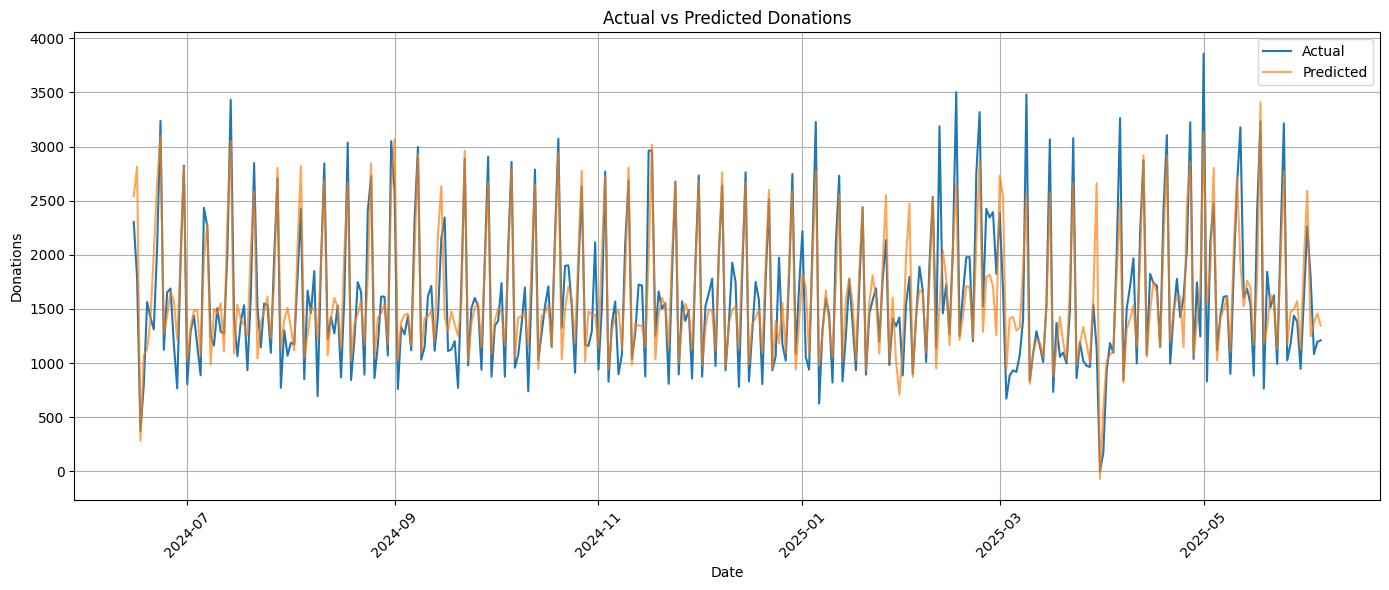

In [14]:
pred_df = pl.DataFrame({'y_true': y_test_scaled.flatten(), 'y_pred': np.round(y_pred).flatten()})

pred_df = pred_df.with_columns(
    (pl.col('y_true') - pl.col('y_pred')).alias('diff')
).with_columns(
    pl.Series("date", df_all[-pred_df.height:]["date"])
)

pred_df = pred_df.with_columns(
    (abs(pl.col('diff')).alias('abs_diff'))
)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pred_df["date"], pred_df["y_true"], label="Actual")
plt.plot(pred_df["date"], pred_df["y_pred"], label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Donations")
plt.xlabel("Date")
plt.ylabel("Donations")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
pred_df.sort(by='abs_diff', descending=True).head(10)

y_true,y_pred,diff,date,abs_diff
f64,f32,f64,date,f64
3188.0,1533.0,1655.0,2025-02-11,1655.0
1136.0,2662.0,-1526.0,2025-03-30,1526.0
3178.0,1927.0,1251.0,2025-05-12,1251.0
1789.0,2814.0,-1025.0,2024-06-16,1025.0
2962.0,1962.0,1000.0,2024-11-16,1000.0
2345.0,1427.0,918.0,2024-09-16,918.0
3481.0,2570.0,911.0,2025-03-09,911.0
1674.0,2532.0,-858.0,2025-03-02,858.0
3503.0,2658.0,845.0,2025-02-16,845.0


While all in all the model seems to be performing well, on certain days it still shows a bigger deviance:
- 2025-02-11: Thaipusam, which is not a national holiday but observed in eight states. Incorporating this can be valuable in the future
- 2025-03-30: The day before Hari Raya Puasa, while not a holiday itself can lead to lower level of donations (preparations etc)
- 2025-03-02: The first day of Ramadan, which also leads to lower actual donations than predicted

Some other days which should have been properly observed still showed some difference:
- 2024-09-16: Malaysia Day
- 2025-05-12: Wesak Day
- 2025-05-01: Labor Day

Based on this it might make sense to extend the low donation holidays to 1 day before/after the actual date.

In [16]:
# Saving the model
model.save(f"shared/model_{experiment_name}.keras")

## Comparison with simple benchmarks

### Comparison with mean value from the validation set

In [17]:
# Comparison with mean value from validation set
mean_val = y_scaler.inverse_transform(y_val.reshape(-1, 1)).mean()

mean_pred = np.full_like(y_test_scaled, mean_val)
mean_absolute_error(y_test_scaled, mean_pred)

526.6071462578556

### Comparison with rolling average

In [18]:
# Concatenate y_train, y_val, and y_test for easy indexing
y_all = np.concatenate([y_val, y_test])

# Indices for the start of y_test in y_all
test_start_idx = len(y_val)

# Rolling average prediction for y_test
rolling_preds = []
for i in range(test_start_idx, test_start_idx + len(y_test)):
    # Take the previous 7 days
    prev_7 = y_all[i-constants.WINDOW_SIZE:i]
    rolling_preds.append(prev_7.mean())

rolling_preds = np.array(rolling_preds)

mean_absolute_error(y_test, 
                    y_scaler.inverse_transform(rolling_preds[-len(y_test):].reshape(-1, 1))
)

1612.5570317883635

We could confirm that using the model is meaningfully better in terms of performance over simple benchmarks.